In [3]:
import os
!mkdir -p ~/.kaggle  # Crea la cartella se non esiste
!mv kaggle.json ~/.kaggle/  # Sposta il file nella cartella corretta
!chmod 600 ~/.kaggle/kaggle.json  # Imposta i permessi per maggiore sicurezza

!kaggle datasets download -d 'kmader/skin-cancer-mnist-ham10000'



Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [4]:
import zipfile

dataset_path = 'skin-cancer-mnist-ham10000.zip'  # Nome del file scaricato
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Estrai i file in una cartella chiamata "dataset"


In [5]:
from PIL import Image
import os
from numpy import asarray

img = Image.open("dataset/HAM10000_images_part_1/ISIC_0024306.jpg")
img_array = asarray(img)
print(img_array.shape)

(450, 600, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
import numpy as np
from tensorflow.keras.applications import EfficientNetB1
import os

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


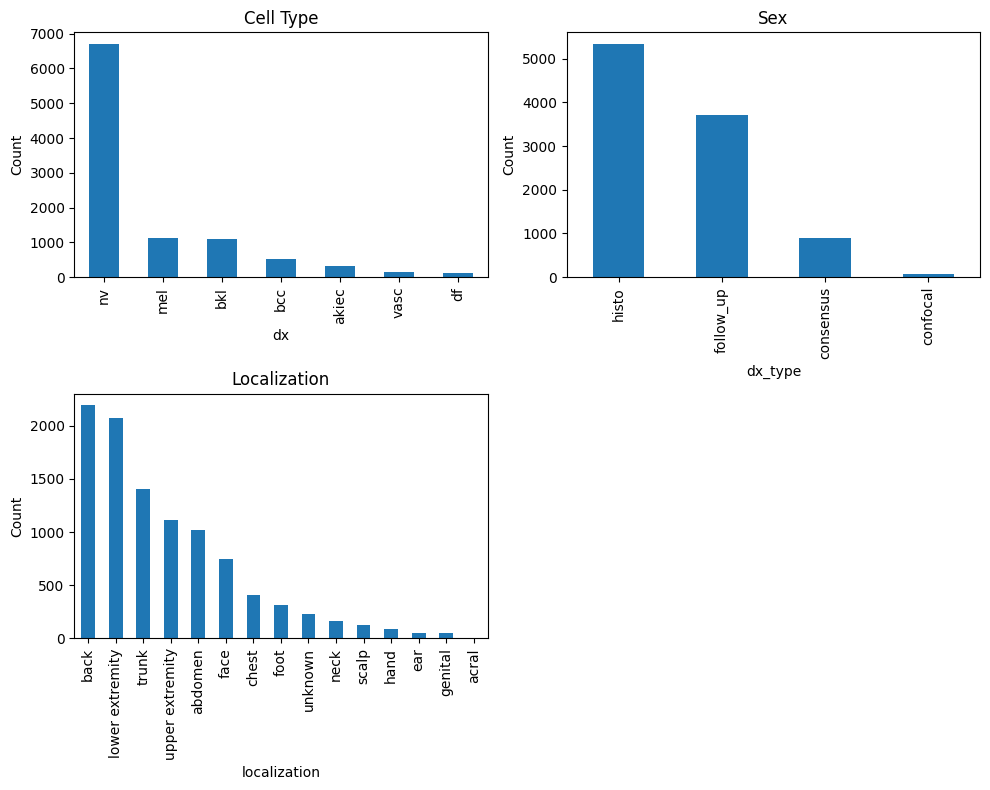

In [7]:
from math import dist
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

#Datast pre-processing
skin_df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])

SIZE = 72

fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(2, 2, 1)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type')

ax2 = fig.add_subplot(2, 2, 2)
skin_df['dx_type'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count')
ax2.set_title('Sex')

ax3 = fig.add_subplot(2, 2, 3)
skin_df['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Count')
ax3.set_title('Localization')


plt.tight_layout()
plt.show()

From the picture above we can clearly see an unbalanced class: we are going to compensate by using balanced weights. An alternative may be to cancel that class, or to augment the others up to a number X, but I believe this is the best approach.


In [8]:
#--------------------------BINARY CLASSIFICATION------------------------------------
import os
import shutil
import pandas as pd

# Dataset paths
metadata_path = "/content/dataset/HAM10000_metadata.csv"
images_part1 = "/content/dataset/ham10000_images_part_1"
images_part2 = "/content/dataset/ham10000_images_part_2"
output_dir = "./ham10000_binary"

# Binary classification folders
binary_labels = ["cancer", "non_cancer"]
for label in binary_labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# Reading the CSV
df = pd.read_csv(metadata_path)

# Binary distinction
malignant_classes = ["mel", "bcc", "akiec"]  # Cancer
benign_classes = ["nv", "bkl", "df", "vasc"]  # Not cancer

# Move the pictures in the respective folders
for _, row in df.iterrows():
    image_name = row["image_id"] + ".jpg"
    label = row["dx"]

    if label in malignant_classes:
        dst_folder = "cancer"
    elif label in benign_classes:
        dst_folder = "non_cancer"
    else:
        continue

    # From source path to destination path
    src_path = os.path.join(images_part1, image_name) if os.path.exists(os.path.join(images_part1, image_name)) else os.path.join(images_part2, image_name)
    dst_path = os.path.join(output_dir, dst_folder, image_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("The dataset was split into two classes: cancer and not_cancer!")


The dataset was split into two classes: cancer and not_cancer!


In [9]:
#--------------------------------YES CANCER VS NO CANCER ------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# I decided to augment data to improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Binary dataset path
data_dir = "./ham10000_binary"

# Training
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),  # Xception uses 299x299
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print("✅ Dataset binario caricato correttamente!")


Found 8013 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.
✅ Dataset binario caricato correttamente!


In [10]:
#To cancel
batch_size = 64
epochs = 20
learning_rate = 0.001
img_size = (72, 72)

In [11]:
#Creating X_train and Y_train

from sklearn.utils import resample
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob
import numpy as np
from PIL import Image

print(skin_df['label'].value_counts())
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/content/dataset/', '*', '*.jpg'))}

skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))


X = np.asarray(skin_df['image_id'].tolist())

X = np.asarray(skin_df['image'].tolist())
X = X/255.
y = np.asarray(skin_df['label'].tolist())
Y_cat = to_categorical(y, num_classes=7)
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=2)

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


In [12]:
#----------------------------------BINARY CLASSIFICATION MODEL-------------------------------

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model

# Cut the head of Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze everything except the latest 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# The head of the model
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Model assembled
model = Model(inputs=base_model.input, outputs=output_layer)

# Model compiled
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint

# Callbacks always useful
checkpoint_callback = ModelCheckpoint(
    filepath="./best_model_duoclass.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)


# I am always checking how many params the model has
model.summary()

# Here the magic happens: I am balancing the weight of the class: the method is going to assign a
# better weight to the less number of pics layers

from sklearn.utils.class_weight import compute_class_weight
import numpy as np


y_train_int = np.argmax(y_train, axis=1)

# Computes class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)


class_weights = dict(enumerate(class_weights))

#You can appreciate how class 5 (the ones with more examples) has the less weight's value
print(class_weights)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Tipo output: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 149, 149, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 149, 149, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 147, 147, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 147, 147, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 147, 147, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 147, 147, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 147, 147, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 147, 147, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 147, 147, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 74, 74, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 21,919,273 (83.62 MB)

 Trainable params: 6,550,017 (24.99 MB)

 Non-trainable params: 15,369,256 (58.63 MB)

{0: np.float64(4.419194704908991), 1: np.float64(2.7848453249913105), 2: np.float64(1.2788507581803672), 3: np.float64(12.577708006279435), 4: np.float64(1.303612105434429), 5: np.float64(0.2131417930300612), 6: np.float64(10.597883597883598)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7766 - loss: 0.5324
Epoch 1: val_accuracy improved from -inf to 0.84416, saving model to ./best_model_duoclass.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.7768 - loss: 0.5320 - val_accuracy: 0.8442 - val_loss: 0.3812
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8533 - loss: 0.3208
Epoch 2: val_accuracy did not improve from 0.84416
251/251 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.8533 - loss: 0.3208 - val_accuracy: 0.8287 - val_loss: 0.3472
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.8582 - loss: 0.3020
Epoch 3: val_accuracy improved from 0.84416 to 0.85215, saving model to ./best_model_duoclass.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.8583 - loss: 0.3020 - val_accuracy: 0.8521 - val_loss: 0.3158
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.8700 - loss: 0.2876
Epoch 4: val_accuracy improved from 0.85215 to 0.86713, saving model to ./best_model_duoclass.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.8700 - loss: 0.2876 - val_accuracy: 0.8671 - val_loss: 0.3010
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8845 - loss: 0.2696
Epoch 5: val_accuracy did not improve from 0.86713
251/251 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8845 - loss: 0.2696 - val_accuracy: 0.8531 - val_loss: 0.3329
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.8944 - loss: 0.2540
Epoch 6: val_accuracy did not improve from 0.86713
251/251 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.8944 - loss: 0.2540 - val_accuracy: 0.8472 - val_loss: 0.3279
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.9019 - loss: 0.2343
Epoch 7: val_accuracy improved from 0.86713 to 0.87413, saving model to ./best_model_duoclass.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.9019 - loss: 0.2344 - val_accuracy: 0.8741 - val_loss: 0.2937
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.9095 - loss: 0.2229
Epoch 8: val_accuracy did not improve from 0.87413
251/251 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.9095 - loss: 0.2230 - val_accuracy: 0.8741 - val_loss: 0.2941
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9123 - loss: 0.2072
Epoch 9: val_accuracy did not improve from 0.87413
251/251 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9123 - loss: 0.2073 - val_accuracy: 0.8457 - val_loss: 0.3425
Epoch 10/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9119 - loss: 0.2065
Epoch 10: val_accuracy improved from 0.87413 to 0.87662, saving model to ./best_model_duoclass.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.9119 - loss: 0.2066 - val_accuracy: 0.8766 - val_loss: 0.3417
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


Text(0.5, 1.0, 'Training and Validation Accuracy')

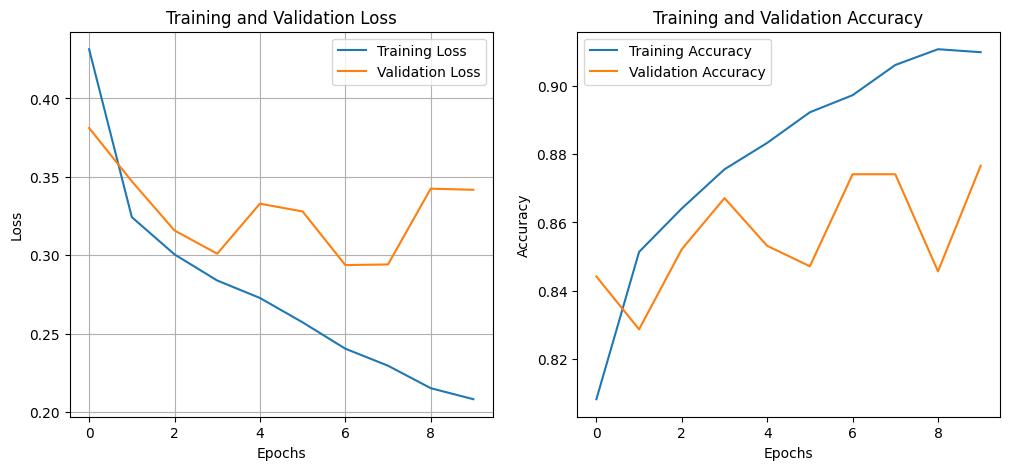

In [13]:
#Model fitting
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        checkpoint_callback
    ]
)


import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


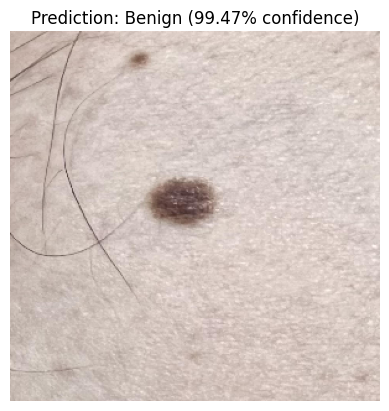

✅ Prediction: Benign (99.47% confidence)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Loading the model
model = load_model("/content/best_model_duoclass.h5")

img_size = (299, 299)

def pre_process_image(image_path, target_size=img_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def predict_image(image_path, threshold=0.6):
    img_array, img = pre_process_image(image_path)
    benign_prob = model.predict(img_array)[0, 0]
    malignant_prob = 1 - benign_prob

    predicted_class = "Benign" if benign_prob > malignant_prob else "Malignant"
    confidence = max(benign_prob, malignant_prob)


    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_class} ({confidence:.2%} confidence)")
    plt.show()

    if confidence < threshold:
        print(f"⚠️ Unsure prediction ({confidence:.2%} confidence). Please check with a doctor.")
    else:
        print(f"✅ Prediction: {predicted_class} ({confidence:.2%} confidence)")

# Example
image_path = "/content/Neo_mio.jpg"
predict_image(image_path, threshold=0.7)


In [36]:
!git remote add origin https://github.com/francescoGrossy/Skin_Cancer_agent.git
!git push -u origin main

error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address


In [5]:
!git add .




In [3]:
%cd /content/Skin_Cancer_agent

/content/Skin_Cancer_agent
